# Walmart Weekly Sales Forecasting

By: Zachary Raup

## Introduction
---

Accurate sales forecasting plays a critical role in the retail industry by informing **inventory planning**, **staff allocation**, and **strategic decision-making**. In this project, historical data from Walmart stores (2010–2012) is used to develop a machine learning pipeline that predicts **weekly retail sales** at the store level.

The dataset includes **calendar-based variables**, **store identifiers**, and **regional economic indicators**, which serve as features for training both **linear** and **non-linear regression models**. Models evaluated include Ridge Regression, Decision Tree, Random Forest, LightGBM, and XGBoost.

Beyond predictive performance, this project emphasizes **model interpretability**, **residual diagnostics**, and **generalizability** through **5-fold cross-validation**. The goal is to not only identify the most accurate model, but also to understand the drivers behind sales variability and how different algorithms handle temporal and economic dynamics.


## Objective
---
- Build and evaluate machine learning regression models to predict weekly sales for Walmart stores.
- Incorporate temporal, economic, and interaction features to enhance model accuracy.
- Compare linear models with tree-based ensemble methods.
- Diagnose model behavior using residual plots, error distributions, and feature importance.
- Identify the most accurate and generalizable model for potential real-world deployment.


## Skills Used
---

- **Python & Libraries**: pandas, numpy, matplotlib, seaborn, scikit-learn, xgboost, lightgbm  
- **Data Cleaning & Preprocessing**: Handling missing values, categorical encoding, feature engineering  
- **Exploratory Data Analysis (EDA)**: KDE plots, skewness metrics, correlation heatmaps, time series decomposition  
- **Modeling Techniques**:
  - Linear Models: Ridge Regression  
  - Tree-Based Models: Decision Tree, Random Forest  
  - Gradient Boosting Models: XGBoost, LightGBM  
- **Model Evaluation**: RMSE, MAE, R², MSE, Average Percentage Error, Residual Analysis, Cross-Validation  
- **Model Interpretation**: Feature importance visualization, residual diagnostics, temporal error analysis  


### Data Overview
---

This dataset, sourced from Kaggle, captures **weekly sales performance** across 45 Walmart stores from **2010 to 2012**. It includes both **store-level operational metrics** and **macro-level economic indicators**, enabling a rich foundation for modeling and feature engineering.

Key features in the dataset include:

- **Store**: Unique identifier for each Walmart store.
- **Date**: Week-ending date of the sales record.
- **Weekly_Sales**: Target variable — total sales for a specific store during a given week (in USD).
- **Holiday_Flag**: Binary indicator (1 = holiday week, 0 = non-holiday), denoting major U.S. holidays such as Super Bowl, Labor Day, Thanksgiving, and Christmas.
- **Temperature**: Average temperature (in Fahrenheit) for the store’s region during the week.
- **Fuel_Price**: Average fuel cost per gallon in the region.
- **CPI (Consumer Price Index)**: A measure of inflation for the regional economy.
- **Unemployment**: Regional unemployment rate (percentage), serving as a proxy for local economic health.

This dataset offers a blend of **temporal**, **store-level**, and **economic** signals, making it well-suited for time-aware regression modeling aimed at **forecasting sales performance**.

## Preprocessing Dataset
---

This section covers the initial steps required to prepare the data for machine learning modeling. After importing the dataset and relevant libraries, the data is previewed and examined for missing values, duplicated rows, and outliers. New features are engineered to capture domain-specific insights such as holiday proximity, interaction effects between fuel prices and temperature, and store-level historical sales patterns. Categorical variables are encoded, and numerical features are standardized in preparation for data analysis and model training.


In [1]:
# --------------------------------------------
# Import Required Libraries
# --------------------------------------------

# System and warning settings
import os
import warnings
warnings.filterwarnings("ignore")

# Core libraries for data manipulation
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Statistical tools
from scipy.stats import skew, uniform, randint, loguniform

# Scikit-learn: preprocessing, model selection, evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Regression models
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Gradient boosting models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
# --------------------------------------------
#  Load & Inspect Data
# --------------------------------------------

# Load Walmart dataset
data_path = '/kaggle/input/walmart-dataset/Walmart.csv'  # Path to the dataset
df = pd.read_csv(data_path)

# Display the shape of the dataset
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

# Display column information and data types for clarity
print("\nDataset Information:")
df.info()
print("")
print("")

print("\nWalmart Store Sales Data (2010-2012):")
# Preview dataset
df.head(10)

The dataset contains 6435 rows and 8 columns.


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB



Walmart Store Sales Data (2010-2012):


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


In [3]:
# --------------------------------------------
#  Clean Data
# --------------------------------------------

# Convert 'Store' to categorical since it's an identifier
df['Store'] = df['Store'].astype('category')

# Convert 'Holiday_Flag' to boolean or category
df['Holiday_Flag'] = df['Holiday_Flag'].astype('category')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

# --- Temporal Features ---
df['Year'] = df['Date'].dt.year                         # Year (e.g., 2010, 2011, ...)
df['Quarter'] = df['Date'].dt.quarter                   # Quarter of the year (1–4)
df['Month'] = df['Date'].dt.month                       # Month (1–12)
df['Week'] = df['Date'].dt.isocalendar().week           # ISO Week number
df['Day'] = df['Date'].dt.day                           # Day of the month

In [4]:
# Check for duplicate rows
duplicates = df[df.duplicated()]
print("Duplicate rows found:\n", duplicates)
print("")


# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print("")

# Display summary statistics for all numeric columns
print("\nSummary Statistics:")
print(df.describe())

Duplicate rows found:
 Empty DataFrame
Columns: [Store, Date, Weekly_Sales, Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment, Year, Quarter, Month, Week, Day]
Index: []

Missing values per column:
 Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Year            0
Quarter         0
Month           0
Week            0
Day             0
dtype: int64


Summary Statistics:
                      Date  Weekly_Sales  Temperature   Fuel_Price  \
count                 6435  6.435000e+03  6435.000000  6435.000000   
mean   2011-06-17 00:00:00  1.046965e+06    60.663782     3.358607   
min    2010-02-05 00:00:00  2.099862e+05    -2.060000     2.472000   
25%    2010-10-08 00:00:00  5.533501e+05    47.460000     2.933000   
50%    2011-06-17 00:00:00  9.607460e+05    62.670000     3.445000   
75%    2012-02-24 00:00:00  1.420159e+06    74.940000     3.735000   
max    2012-10-26 00:00:00  3.81868

In [5]:
# --------------------------------------------
#  Outlier Detection 
# --------------------------------------------

#  Define a function to detect outlier rows using the IQR method
def find_outlier_rows(df, col, level='both'):
    """Returns rows with outliers in the given column using IQR method."""
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

#  Count outliers in each numeric column
def count_outliers(df):
    """Returns a summary of outlier counts and percentages for each numeric column."""
    df_numeric = df.select_dtypes(include=['int', 'float'])
    columns = df_numeric.columns

    # Identify columns with at least one outlier
    outlier_cols = [col for col in columns if not find_outlier_rows(df_numeric, col).empty]

    outliers_df = pd.DataFrame(columns=['Outlier Count', 'Outlier Percent'])

    for col in outlier_cols:
        count = len(find_outlier_rows(df_numeric, col))
        percent = round((count / len(df)) * 100, 2)
        outliers_df.loc[col] = [count, percent]

    return outliers_df.sort_values('Outlier Count', ascending=False)

#  Display outlier counts by column
print(" Outlier Count Summary by Column:")
display(count_outliers(df))

#  Show summary statistics for outlier values in key columns
columns_to_analyze = ['Unemployment', 'Weekly_Sales', 'Temperature']

for col in columns_to_analyze:
    outliers = find_outlier_rows(df, col)
    print(f"\n Descriptive Statistics for Outliers in '{col}':")
    display(outliers[col].describe())


 Outlier Count Summary by Column:


,Outlier Count,Outlier Percent
Unemployment,481.0,7.47
Weekly_Sales,34.0,0.53
Temperature,3.0,0.05



 Descriptive Statistics for Outliers in 'Unemployment':


count    481.000000
mean      11.447480
std        3.891387
min        3.879000
25%       11.627000
50%       13.503000
75%       14.021000
max       14.313000
Name: Unemployment, dtype: float64


 Descriptive Statistics for Outliers in 'Weekly_Sales':


count    3.400000e+01
mean     3.086723e+06
std      3.794367e+05
min      2.727575e+06
25%      2.767649e+06
50%      2.913971e+06
75%      3.474992e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64


 Descriptive Statistics for Outliers in 'Temperature':


count    3.000000
mean     3.236667
std      4.600004
min     -2.060000
25%      1.740000
50%      5.540000
75%      5.885000
max      6.230000
Name: Temperature, dtype: float64

In [6]:
# --------------------------------------------
#  Feature Engineering for Walmart Sales Data
# --------------------------------------------

# --- Economic & Contextual Features ---
df['Employment'] = 100 - df['Unemployment']             # Estimated employment rate
df['Economic_Stress'] = df['CPI'] * df['Unemployment']  # Proxy for economic tension
df['Fuel_Temp_Interaction'] = df['Fuel_Price'] * df['Temperature']  # Interaction term

# --- Holiday Context Features ---
df['Is_PreHoliday'] = df['Holiday_Flag'].shift(-1).fillna(0).astype(int)  # Week before a holiday
df['Is_PostHoliday'] = df['Holiday_Flag'].shift(1).fillna(0).astype(int)  # Week after a holiday

# --- Store-Level Aggregated Features ---
df['Store_Avg_Sales'] = df.groupby('Store')['Weekly_Sales'].transform('mean')  # Avg sales per store
df['Store_Sales_Deviation'] = df['Weekly_Sales'] - df['Store_Avg_Sales']       # Deviation from store average

# Convert temporal features to categorica
df['Year'] = df['Year'].astype('category')
df['Quarter'] = df['Quarter'].astype('category')
df['Month'] = df['Month'].astype('category')
df['Week'] = df['Week'].astype('category')
df['Day'] = df['Day'].astype('category')

# Binary flags to categorical
df['Is_PreHoliday'] = df['Is_PreHoliday'].astype('category')
df['Is_PostHoliday'] = df['Is_PostHoliday'].astype('category')

# Preview the enriched dataset
print(df.head(3))


  Store       Date  Weekly_Sales Holiday_Flag  Temperature  Fuel_Price  \
0     1 2010-02-05    1643690.90            0        42.31       2.572   
1     1 2010-02-12    1641957.44            1        38.51       2.548   
2     1 2010-02-19    1611968.17            0        39.93       2.514   

          CPI  Unemployment  Year Quarter Month Week Day  Employment  \
0  211.096358         8.106  2010       1     2    5   5      91.894   
1  211.242170         8.106  2010       1     2    6  12      91.894   
2  211.289143         8.106  2010       1     2    7  19      91.894   

   Economic_Stress  Fuel_Temp_Interaction Is_PreHoliday Is_PostHoliday  \
0      1711.147080              108.82132             1              0   
1      1712.329028               98.12348             0              0   
2      1712.709792              100.38402             0              1   

   Store_Avg_Sales  Store_Sales_Deviation  
0     1.555264e+06           88426.502448  
1     1.555264e+06           

### Preprocessing Analysis
---

No missing values were found in the dataset, and duplicate entries were not present. Several extreme values were identified through distributional plots and skewness metrics, particularly in `Weekly_Sales` and `Store_Sales_Deviation`. However, these outliers appear realistic given the business context (e.g., holiday spikes or large-format stores) and were retained.

Feature engineering introduced several meaningful variables, including:
- **Is_PreHoliday** and **Is_PostHoliday** flags,
- **Fuel_Temp_Interaction** to capture weather-related demand signals,
- **Economic_Stress Index** combining CPI and unemployment,
- **Store_Sales_Deviation** for tracking store-level performance relative to historical norms.

These engineered features were designed to enhance model interpretability and improve predictive accuracy.

---

## Exploratory Data Analysis (EDA)
---

This section explores the structure and underlying patterns in the dataset to guide modeling decisions. Through visualizations such as KDE plots, correlation heatmaps, and time series charts, the analysis identifies key trends, outliers, and relationships between variables.

The goal of this section is to:
- Understand the distribution of numerical variables,
- Detect multicollinearity or redundancies,
- Uncover seasonal patterns in sales,
- Quantify the impact of holidays and time-based trends,
- Identify which features are likely to be informative predictors.

These insights form the foundation for model selection, feature engineering, and performance evaluation in the later stages of the project.


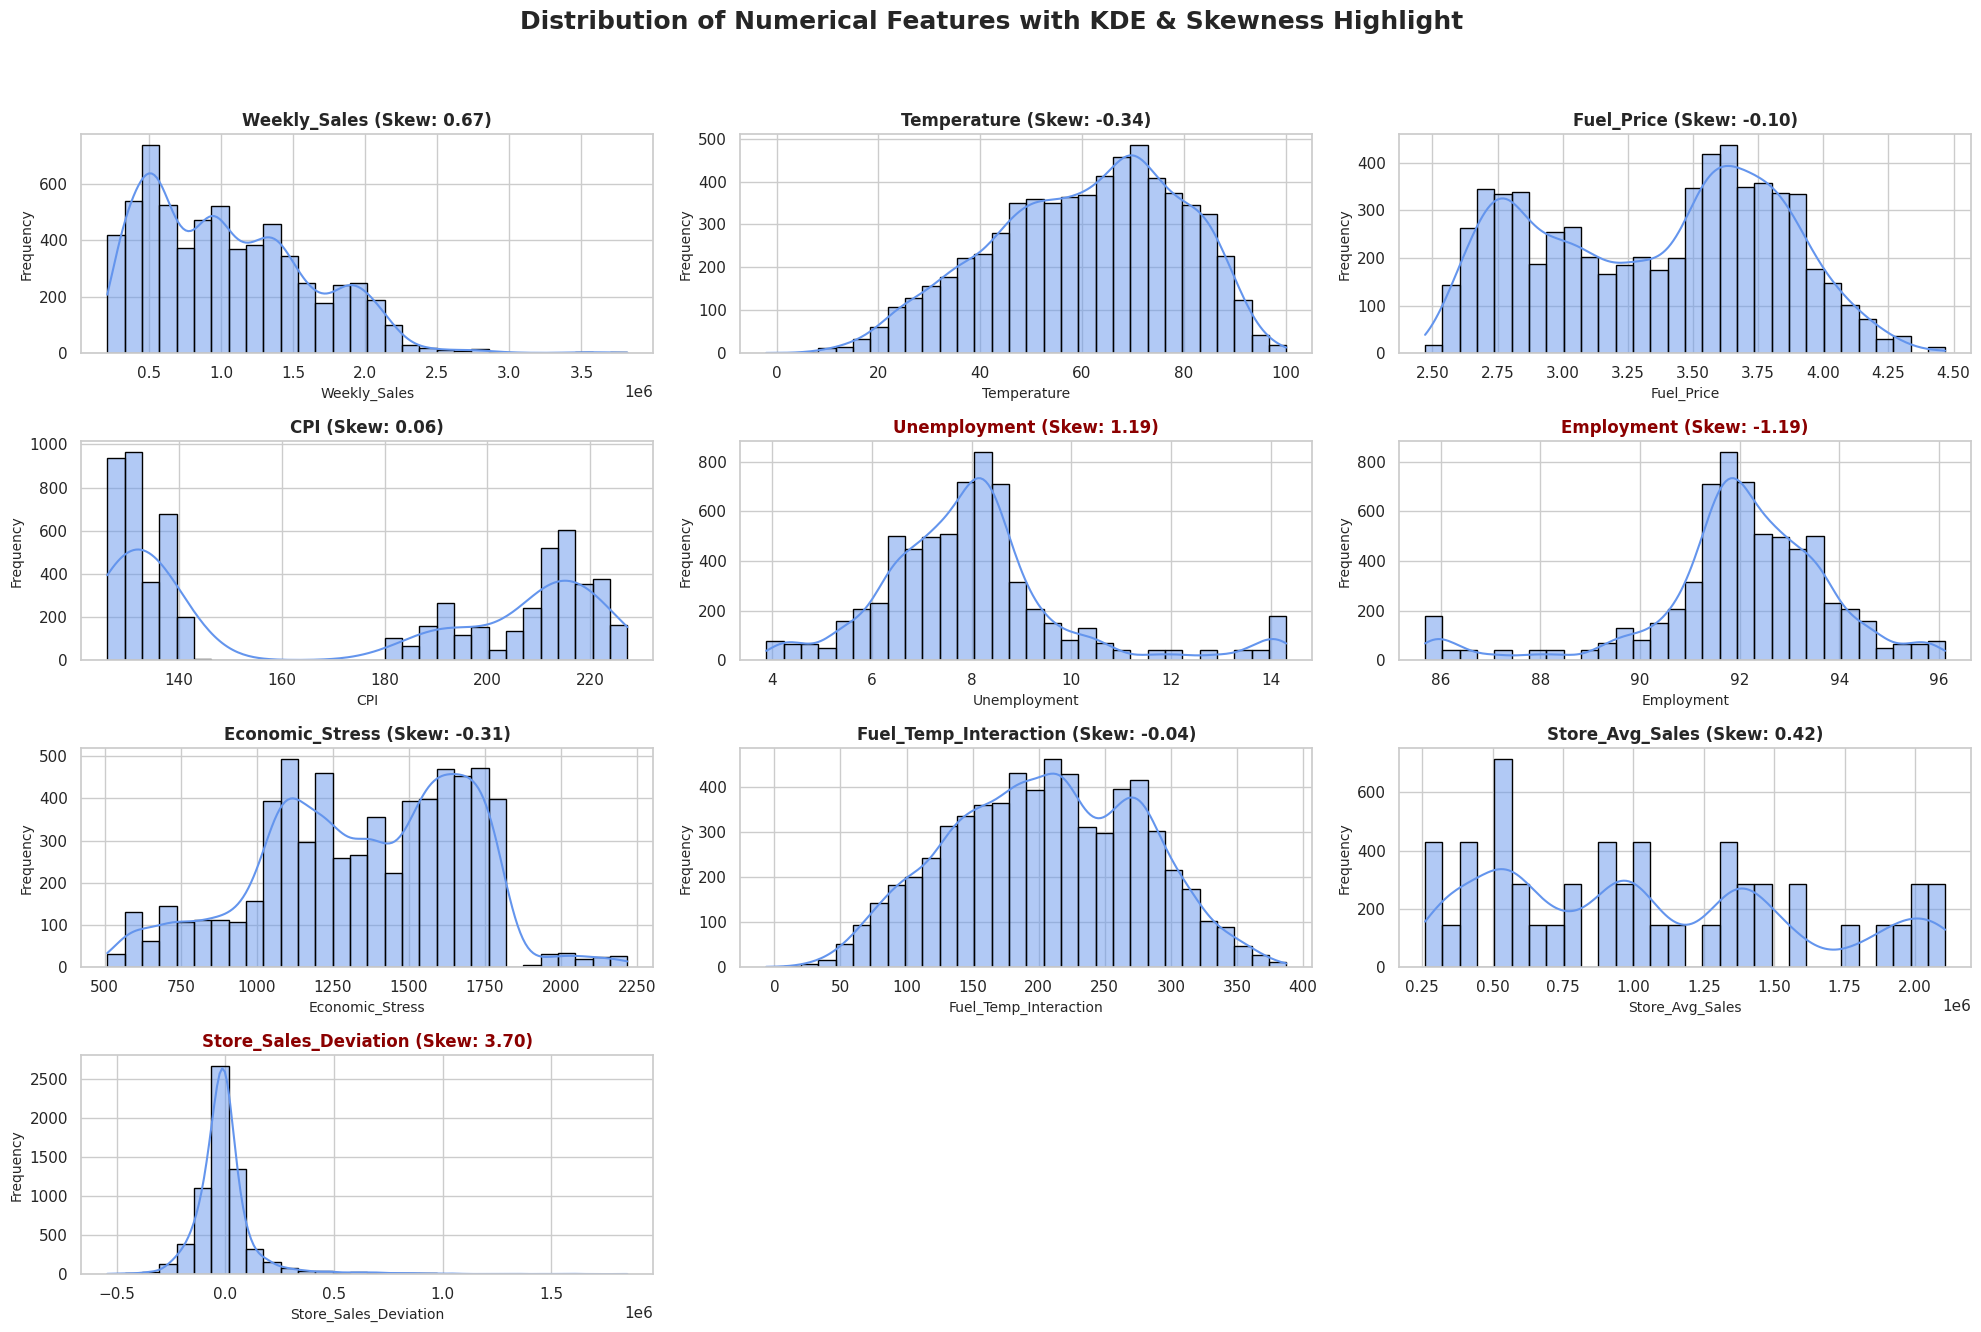

In [7]:
# ------------------------------------------
#  Feature Distributions
# ------------------------------------------

# Set seaborn style for clean visuals
sns.set(style="whitegrid")

# Select only numeric features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate skewness for each feature
skewness = df[numeric_cols].apply(skew).sort_values(ascending=False)

# Set plot layout
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 14))
axes = axes.flatten()

# Plot histograms with KDE overlay and skewness info
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, color='cornflowerblue', edgecolor='black', ax=axes[i])

    skew_val = skewness[col]
    skew_label = f" (Skew: {skew_val:.2f})"

    # Highlight skewed features with a red title
    if abs(skew_val) > 1:
        axes[i].set_title(f"{col}{skew_label}", fontsize=12, fontweight='bold', color='darkred')
    else:
        axes[i].set_title(f"{col}{skew_label}", fontsize=12, fontweight='bold')

    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global title
fig.suptitle('Distribution of Numerical Features with KDE & Skewness Highlight', 
             fontsize=18, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Figure 1: Distribution of Numerical Features with KDE and Skewness Metrics**

This matrix of histograms visualizes the distribution of each numerical feature in the dataset, overlaid with Kernel Density Estimates (KDE) and annotated skewness values. Most variables, such as `Temperature`, `Fuel_Price`, and `Economic_Stress`, exhibit near-normal distributions with low skewness (skew < 0.5). In contrast, `Store_Sales_Deviation` displays **heavy right skew (3.70)**, and `Weekly_Sales` shows **moderate positive skew (0.67)**—highlighting the presence of high-value outliers.

Notably:
- `Unemployment` and `Employment` have symmetric but non-Gaussian shapes with mild skew.
- Interaction terms like `Fuel_Temp_Interaction` and derived metrics such as `Economic_Stress` show compact, centralized distributions.
- The presence of skew and kurtosis in key features supports the need for **scaling**, **normalization**, and robust models that handle non-linearity and outliers effectively.

This analysis also informs preprocessing decisions (e.g., transformations or robust regression techniques) and feature selection for downstream modeling.


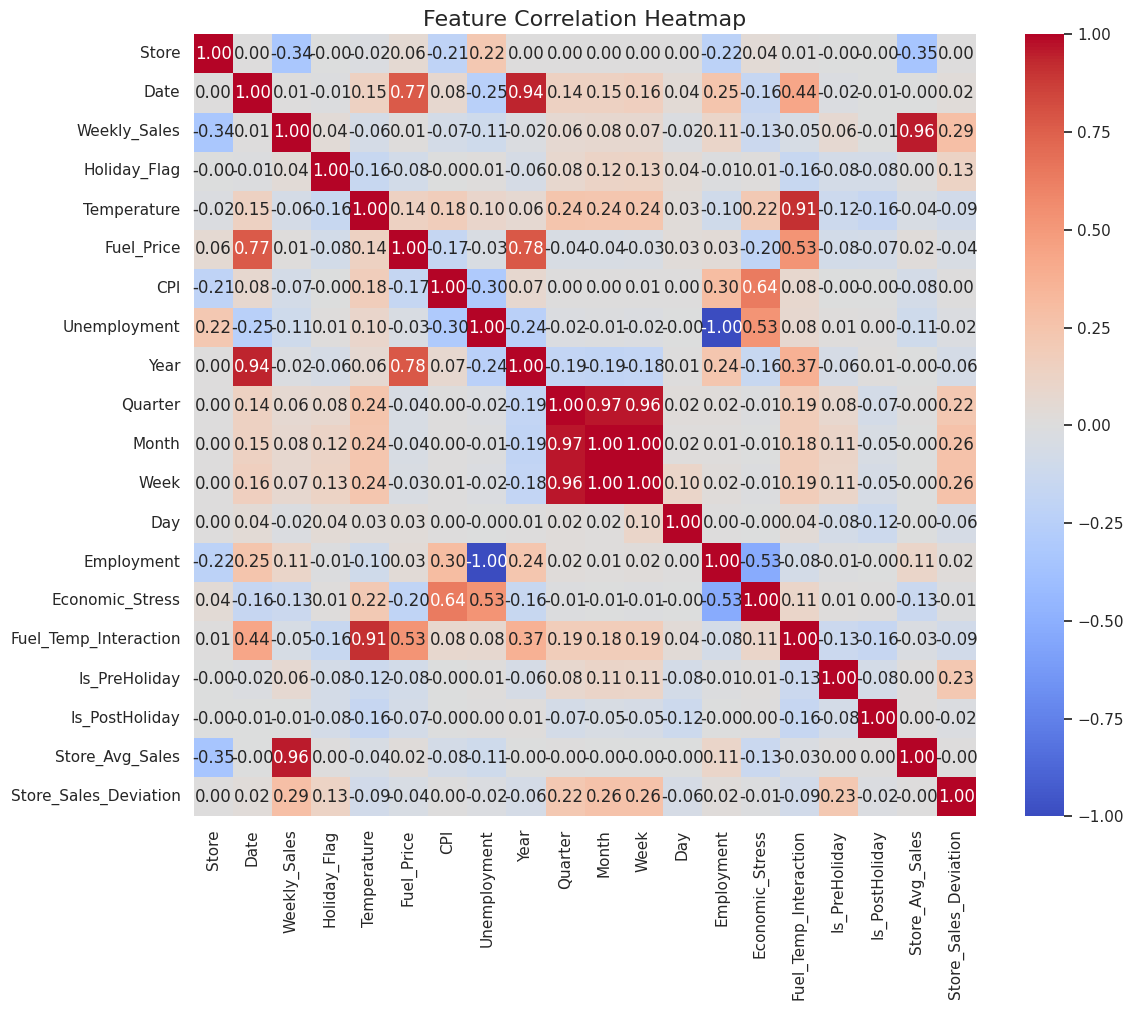

In [8]:
# ------------------------------------------
#  Correlation Heatmap
# ------------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

**Figure 2: Correlation Heatmap of Numeric Features**  
This heatmap highlights pairwise correlations among numerical features. `Store_Avg_Sales` is strongly positively correlated with `Weekly_Sales` (r = 0.96), while `Store` number shows a moderate negative correlation (r = -0.34), suggesting older stores may outperform newer ones. Most other features exhibit weak or negligible correlations with sales, justifying non-linear modeling approaches.

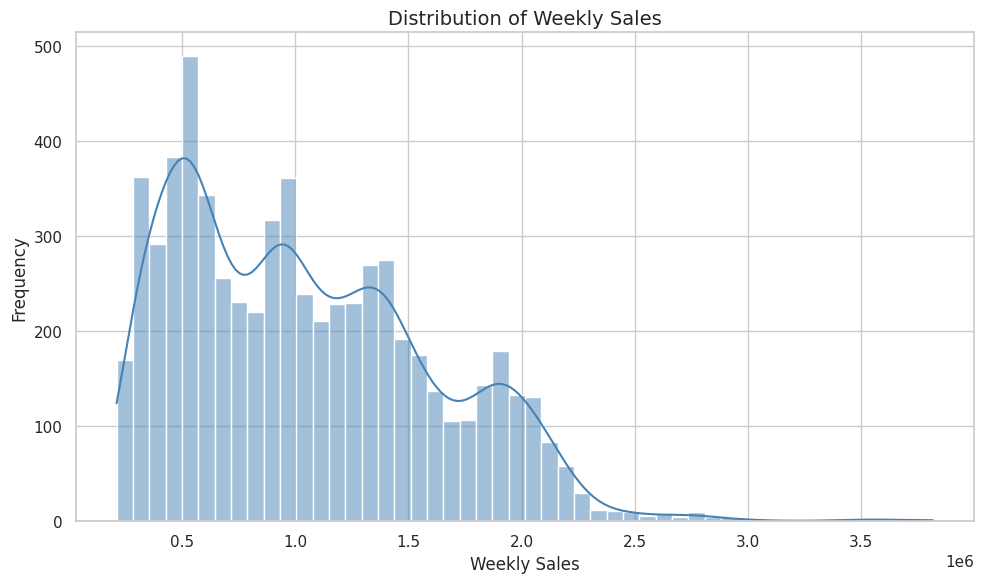

In [9]:
# ------------------------------------------
#  Weekly Sales Distribution
# ------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Weekly Sales", fontsize=14)
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

**Figure 3: Weekly Sales Distribution with KDE**  
`Weekly_Sales` are heavily right-skewed, with a median of `~$961K` and 75% of values below `~$1.42M`. Around 5% of weeks exceed `~$2.05M` in sales, indicating strong seasonal or promotional peaks. The presence of outliers and a wide spread underscores the complexity of the retail sales pattern.


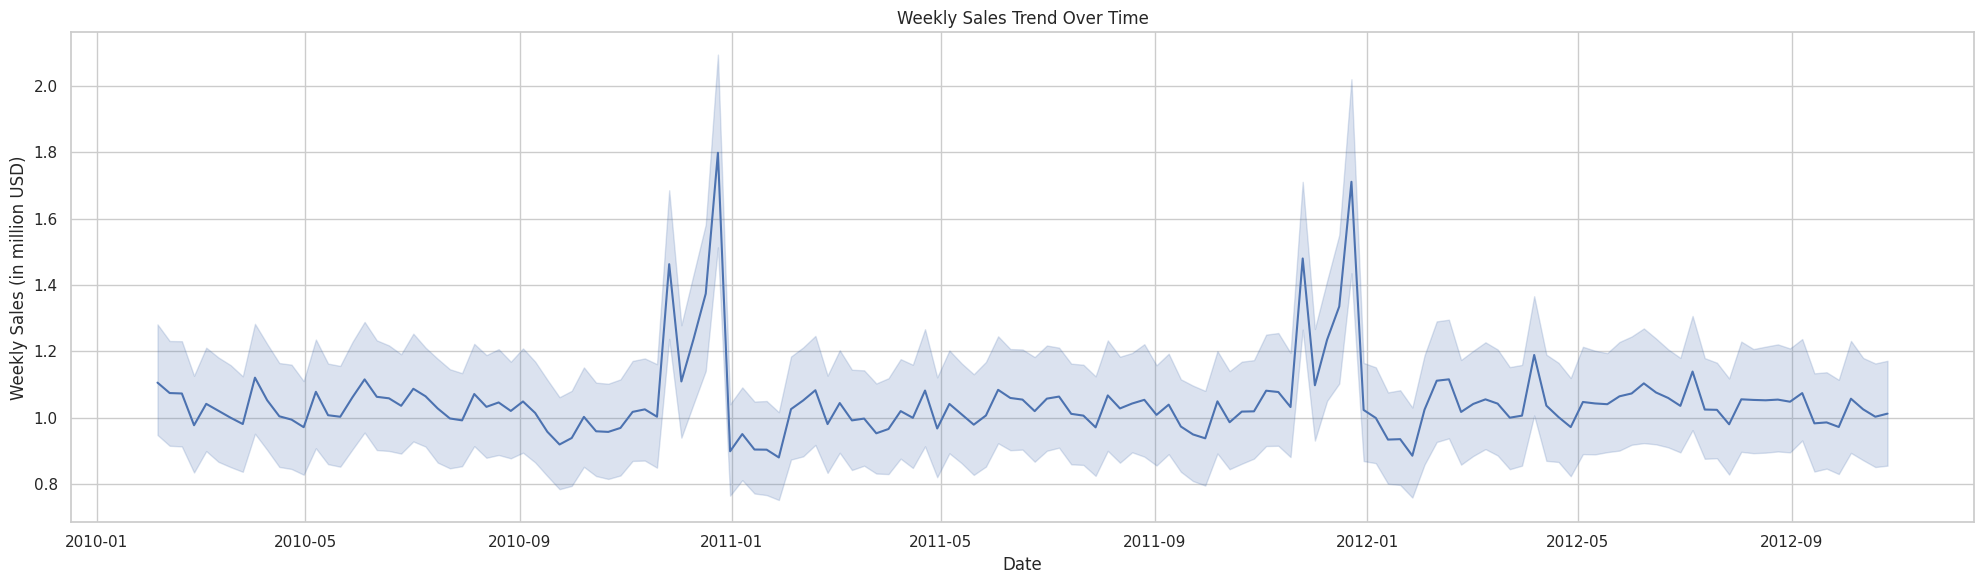

In [10]:
# ------------------------------------------
#  Weekly Sales Over Time
# ------------------------------------------
plt.figure(figsize=(20, 6))
sns.lineplot(x=df['Date'], y=df['Weekly_Sales'] / 1e6)
plt.xlabel('Date')
plt.ylabel('Weekly Sales (in million USD)')
plt.title('Weekly Sales Trend Over Time')
plt.tight_layout()
plt.show()

**Figure 4: Total Weekly Sales Over Time (2010–2012)**  
Sales aggregated weekly show a gradual downward trend from 2010 to 2012, with cyclical spikes near year-end. The average weekly sales across all stores hover around `~$204M`, with variability between `~$164M` and `~$288M`, supporting the need for temporal features and trend modeling.

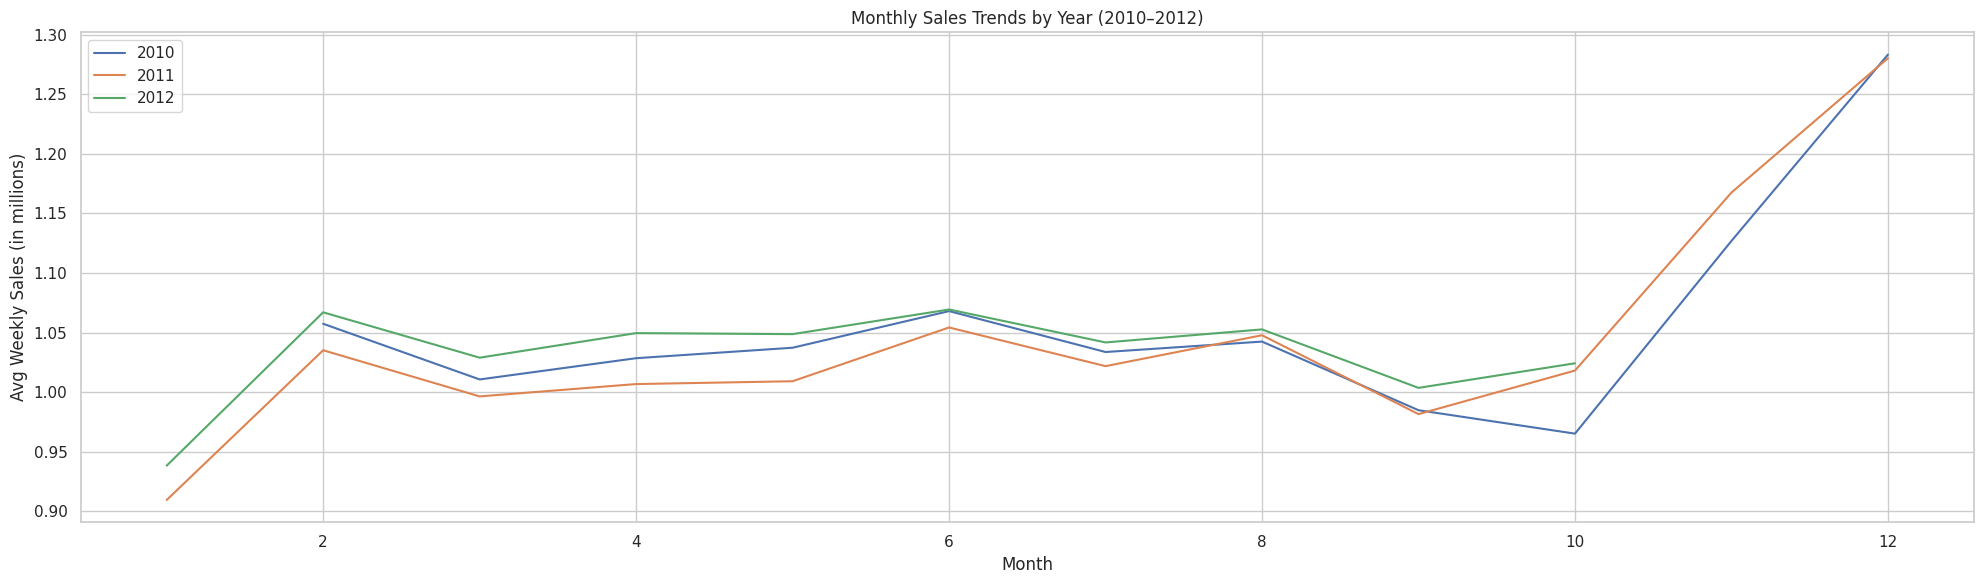

In [11]:
# ------------------------------------------
#  Monthly Sales Trends (2010-2012)
# ------------------------------------------
pivot_table = df.pivot_table(index='Month', columns='Year', values='Weekly_Sales')

plt.figure(figsize=(20, 6))
for year in pivot_table.columns:
    sns.lineplot(x=pivot_table.index, y=pivot_table[year] / 1e6, label=str(year))

plt.ylabel('Avg Weekly Sales (in millions)')
plt.title('Monthly Sales Trends by Year (2010–2012)')
plt.xlabel('Month')
plt.legend()
plt.tight_layout()
plt.show()

**Figure 5: Monthly Average Sales by Year**  
The strongest sales consistently occur in December and November, with average weekly sales of `~$1.28M` and `$1.15M` respectively, confirming seasonal spikes around holidays. Sales in January are the lowest (`~$923K`), making seasonality a key driver in the predictive model.

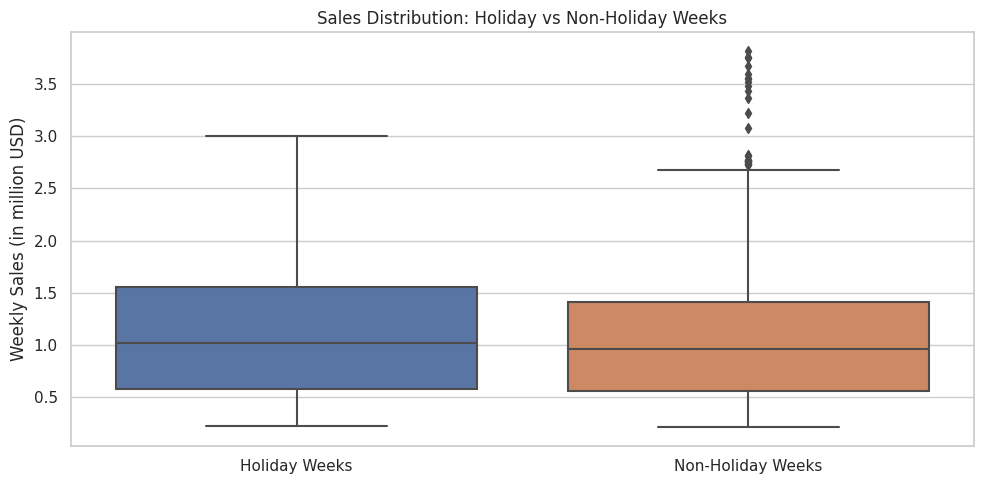

In [12]:
# ------------------------------------------
#  Holiday vs Non-Holiday Weekly Sales
# ------------------------------------------
non_holiday_sales = df[df['Holiday_Flag'] == 0]
holiday_sales = df[df['Holiday_Flag'] == 1]

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=[holiday_sales['Weekly_Sales']/1e6, non_holiday_sales['Weekly_Sales']/1e6], ax=ax)
ax.set_xticklabels(['Holiday Weeks', 'Non-Holiday Weeks'])
ax.set_ylabel('Weekly Sales (in million USD)')
ax.set_title('Sales Distribution: Holiday vs Non-Holiday Weeks')
plt.tight_layout()
plt.show()

**Figure 6: Weekly Sales: Holiday vs. Non-Holiday Weeks**  
Holiday weeks outperform non-holiday weeks by an average of `~$82K` in weekly sales (`$1.12M` vs. `$1.04M`). The holiday weeks also have a wider spread and higher upper quartiles, showing the potential for sales surges tied to specific events.

### EDA Summary
---
The exploratory analysis provided key insights into the distribution, trends, and relationships within the Walmart weekly sales dataset (2010–2012):

- **Weekly Sales Distribution:** Sales are significantly right-skewed, with the majority of weeks showing moderate performance and a few extreme highs due to promotions or holidays. The average weekly sales are approximately `$1.05M`, with a high standard deviation of `$564K`, indicating substantial variability across weeks.

- **Temporal Trends:** A clear seasonality is evident, with major spikes in November and December across all three years. January typically sees the lowest sales. This seasonal pattern highlights the importance of incorporating temporal features like `Month`, `Quarter`, and `Holiday_Flag`.

- **Holiday vs. Non-Holiday Weeks:** Holiday weeks consistently outperform non-holiday weeks, with an average difference of approximately `$82K`. This emphasizes the predictive value of holiday-related features (`Holiday_Flag`, `Is_PreHoliday`, `Is_PostHoliday`).

- **Sales Over Time:** Total weekly sales across all stores showed cyclical spikes near year-end but a subtle declining trend overall. These trends suggest potential external economic or organizational factors influencing sales.

- **Store-Level Insights:** Stores with lower numerical IDs (e.g., Store 4 and Store 20) tend to generate higher average weekly sales, while higher-numbered stores generally underperform. This may relate to store age, customer base, or location.

- **Feature Correlations:** `Store_Avg_Sales` has a very strong positive correlation with `Weekly_Sales` (r = 0.96), whereas `Store` number has a moderate negative correlation (r = -0.34). Most other features, including economic indicators, show weak linear correlation with sales, suggesting the need for non-linear modeling techniques.

These findings informed the feature engineering strategy and reinforced the decision to use advanced regression models capable of capturing complex patterns in the data.

## Regression Modeling and Evaluation
---

To forecast weekly sales, a range of supervised learning models were implemented and compared. These models span from linear approaches to advanced ensemble-based regressors, enabling a comprehensive performance evaluation across complexity, interpretability, and generalizability.

##### ***Models Used***

- **Ridge Regression**: A regularized linear regression model that mitigates overfitting by penalizing large coefficients (L2 regularization). While it assumes a linear relationship between features and target, it provides a strong baseline and is robust in high-dimensional feature spaces.

- **Decision Tree Regressor**: A non-parametric model that recursively splits the feature space to minimize prediction error. Trees capture non-linear patterns and interactions between variables, but can easily overfit without pruning or regularization.

- **Random Forest Regressor**: An ensemble of multiple decision trees trained on bootstrapped samples. It reduces overfitting by averaging predictions and introduces randomness in feature selection, making it more stable and accurate than a single tree.

- **XGBoost Regressor**: A powerful gradient boosting algorithm that builds trees sequentially to correct the errors of previous trees. It incorporates regularization, handles missing values internally, and supports parallel training — making it highly performant on structured/tabular data.

- **LightGBM Regressor**: A gradient boosting framework optimized for efficiency and scalability. It grows trees leaf-wise (rather than level-wise like XGBoost), which often leads to faster convergence and better accuracy. LightGBM can handle large datasets and complex feature interactions with minimal tuning.

##### ***Evaluation Metrics***

To assess and compare these models, a suite of evaluation metrics was used:

- **R² (Coefficient of Determination)**: Measures the proportion of variance in the target variable explained by the model. Higher values (closer to 1.0) indicate better performance.

- **RMSE (Root Mean Squared Error)**: Represents the standard deviation of residuals, providing an interpretable measure of typical prediction error.

- **MSE (Mean Squared Error)**: Captures the average squared difference between predicted and actual values; useful for emphasizing large errors.

- **MAE (Mean Absolute Error)**: Reflects the average magnitude of errors in predictions, and is less sensitive to outliers compared to RMSE.

- **Average Percentage Error**: Expresses error relative to actual values, offering a scale-independent measure useful for business interpretation.

- **Residual Analysis**: Visual diagnostics (residual plots, distribution, temporal trends) are used to assess bias, variance, and potential patterns the models might miss.

- **Cross-Validation (5-Fold)**: Ensures the reliability and generalizability of model performance by evaluating them on multiple train-test splits.

This multi-metric approach ensures a balanced assessment of each model's accuracy, robustness, and suitability for retail demand forecasting.



In [13]:
# -------------------------
# Data Preparation
# -------------------------

# Drop columns that could leak target info or are no longer needed
df.drop([
    'Date',                   # Already extracted temporal features
    'Unemployment',           # Used to create 'Employment'
    'Store_Sales_Deviation',  # Derived from target → target leakage
    'Is_PostHoliday',         # Leaks future info
    'Store_Avg_Sales'         # Derived from target → leakage
], axis=1, inplace=True)

# Separate features and target
X = df.drop('Weekly_Sales', axis=1).copy()
y = df['Weekly_Sales'].copy()

# Set Store as categorical
X['Store'] = X['Store'].astype('category')

# Train-test split (before encoding/scaling)
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# Preprocessing for Ridge, Tree, Forest (One-Hot + Scaling)
# -------------------------

# One-hot encode 'Store' for models that require numeric input
X_train_enc = pd.get_dummies(X_train_full, columns=['Store'], drop_first=True)
X_test_enc = pd.get_dummies(X_test_full, columns=['Store'], drop_first=True)

# Align columns
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

# -------------------------
# Preprocessing for XGBoost and LGBM (No one-hot, Store kept categorical)
# -------------------------

X_train_boost = X_train_full.copy()
X_test_boost = X_test_full.copy()


In [14]:
# -------------------------
# Model Initialization
# -------------------------

ridge = Ridge()
tree = DecisionTreeRegressor(random_state=42)
forest = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(enable_categorical=True, random_state=42, verbosity=0)
lgbm = LGBMRegressor(random_state=42, verbose=-1)

# -------------------------
# Parameter Grids
# -------------------------

param_grid_ridge = {'alpha': loguniform(1e-2, 10)}

param_grid_tree = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

param_grid_forest = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

param_grid_xgb = {
    'n_estimators': randint(100, 200),
    'learning_rate': loguniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

param_grid_lgbm = {
    'n_estimators': randint(100, 300),
    'learning_rate': loguniform(0.01, 0.1),
    'num_leaves': randint(31, 128),
    'min_child_samples': randint(5, 30),
    'reg_alpha': loguniform(1e-3, 0.5),
    'reg_lambda': loguniform(1e-3, 0.5)
}

# -------------------------
# Randomized Hyperparameter Search
# -------------------------

searches = {
    'Ridge': RandomizedSearchCV(ridge, param_grid_ridge, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise'),
    'Decision Tree': RandomizedSearchCV(tree, param_grid_tree, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise'),
    'Random Forest': RandomizedSearchCV(forest, param_grid_forest, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise'),
    'XGBoost': RandomizedSearchCV(xgb, param_grid_xgb, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise'),
    'LGBM': RandomizedSearchCV(lgbm, param_grid_lgbm, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise')
}

# -------------------------
# Execute Search and Display Results
# -------------------------

results = {}
for name, search in searches.items():
    print(f"Tuning {name}...")
    if name in ['Ridge', 'Decision Tree', 'Random Forest']:
        search.fit(X_train_scaled, y_train)
        y_pred = search.best_estimator_.predict(X_test_scaled)
    else:
        search.fit(X_train_boost, y_train)
        y_pred = search.best_estimator_.predict(X_test_boost)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Best Params for {name}: {search.best_params_}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print("-" * 50)

    results[name] = {
        'estimator': search.best_estimator_,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }


Tuning Ridge...
Best Params for Ridge: {'alpha': 0.011527987128232402}
  RMSE: 150430.44
  R²:   0.9298
--------------------------------------------------
Tuning Decision Tree...
Best Params for Decision Tree: {'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 3}
  RMSE: 278116.52
  R²:   0.7599
--------------------------------------------------
Tuning Random Forest...
Best Params for Random Forest: {'max_depth': 29, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 114}
  RMSE: 137528.72
  R²:   0.9413
--------------------------------------------------
Tuning XGBoost...
Best Params for XGBoost: {'colsample_bytree': 0.9908753883293675, 'learning_rate': 0.10196967939171485, 'max_depth': 4, 'n_estimators': 173, 'subsample': 0.9684482051282945}
  RMSE: 61407.03
  R²:   0.9883
--------------------------------------------------
Tuning LGBM...
Best Params for LGBM: {'learning_rate': 0.07643288611715515, 'min_child_samples': 27, 'n_estimators': 191, 'num_leaves': 119, 

In [15]:
# -------------------------
# Evaluation Functions
# -------------------------

def evaluate_regressors_metrics(regressors, regressor_names, 
                                 X_train_scaled, y_train, X_test_scaled, y_test,
                                 X_train_boost, X_test_boost):
    metrics = []
    all_preds = []
    fitted_models = []

    for i, regressor in enumerate(regressors):
        name = regressor_names[i]
        if name in ['Ridge Regression', 'Decision Tree Regression', 'Random Forest']:
            X_test_in = X_test_scaled
        else:
            X_test_in = X_test_boost

        y_pred = regressor.predict(X_test_in)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        metrics.append([mse, rmse, mae, r2])
        all_preds.append(y_pred)
        fitted_models.append(regressor)

    metrics_df = pd.DataFrame(metrics, columns=['MSE', 'RMSE', 'MAE', 'R2'])
    metrics_df['Regressor'] = regressor_names
    metrics_df = metrics_df.sort_values('RMSE').reset_index(drop=True)

    all_preds = [all_preds[i] for i in metrics_df.index]
    fitted_models = [fitted_models[i] for i in metrics_df.index]
    return metrics_df, all_preds, fitted_models


In [16]:
# -------------------------
# Final Model Evaluation
# -------------------------

regressors = [searches[name].best_estimator_ for name in searches]
regressor_names = [
    "Ridge Regression", "Decision Tree Regression", "Random Forest",
    "XGBoost Regression", "LightGBM Regression"
]

metrics_df, all_preds, fitted_models = evaluate_regressors_metrics(
    regressors, regressor_names,
    X_train_scaled, y_train, X_test_scaled, y_test,
    X_train_boost, X_test_boost
)

best_model_index = metrics_df['RMSE'].idxmin()
best_model_name = metrics_df.loc[best_model_index, 'Regressor']
best_rmse = metrics_df.loc[best_model_index, 'RMSE']
best_r2 = metrics_df.loc[best_model_index, 'R2']
best_model_instance = fitted_models[best_model_index]
y_pred = all_preds[best_model_index]
median_sale = y_test.median()
percent_deviation = round((best_rmse * 100 / median_sale), 2)


# Print summary
print("Regressor Results")
print(metrics_df)
print()
print()

print(f"Best Model: {best_model_name}")
print(f"Best RMSE: {best_rmse:.2f}")
print(f"Best R²:   {best_r2:.4f}")
print(f"Average % Error: {percent_deviation}%")
print()



Regressor Results
            MSE           RMSE            MAE        R2  \
0  3.770823e+09   61407.030126   40221.158421  0.988295   
1  4.128511e+09   64253.488527   39010.862096  0.987185   
2  1.891415e+10  137528.718128   78195.749743  0.941289   
3  2.262932e+10  150430.442244   95225.774770  0.929756   
4  7.734880e+10  278116.524073  193609.298006  0.759902   

                  Regressor  
0        XGBoost Regression  
1       LightGBM Regression  
2             Random Forest  
3          Ridge Regression  
4  Decision Tree Regression  


Best Model: XGBoost Regression
Best RMSE: 61407.03
Best R²:   0.9883
Average % Error: 6.34%



**Figure 7: Regression Model Performance Summary**  
This table summarizes the RMSE, MSE, and R² scores for five regression models. The **XGBoost Regression** model performs best with an RMSE of **~$54.8K** and R² of **0.990**, outperforming all others. The Random Forest and Decision Tree regressors also perform well (R² > 0.97), whileRidge and KNN regressors show comparatively weaker performance (R² < 0.95).



In [17]:
# -------------------------
# Verify Results with Cross Validation
# -------------------------


# Store results
cv_scores = {'XGBoost': [], 'LGBM': []}
cv_r2s = {'XGBoost': [], 'LGBM': []}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df.drop(['Weekly_Sales'], axis=1).copy()
y = df['Weekly_Sales'].copy()

# Cast Store to categorical explicitly (ensures compatibility)
X['Store'] = X['Store'].astype('category')

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")

    # Split the fold
    X_train_fold = X.iloc[train_idx].copy()
    X_val_fold = X.iloc[val_idx].copy()
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    # Ensure categorical type is preserved
    X_train_fold['Store'] = X_train_fold['Store'].astype('category')
    X_val_fold['Store'] = X_val_fold['Store'].astype('category')

    # ----------------------
    # XGBoost
    # ----------------------
    
    xgb_fold = XGBRegressor(
        **results['XGBoost']['estimator'].get_params()
)
    
    xgb_fold.fit(X_train_fold, y_train_fold)
    y_pred_xgb = xgb_fold.predict(X_val_fold)

    rmse_xgb = np.sqrt(mean_squared_error(y_val_fold, y_pred_xgb))
    r2_xgb = r2_score(y_val_fold, y_pred_xgb)

    cv_scores['XGBoost'].append(rmse_xgb)
    cv_r2s['XGBoost'].append(r2_xgb)

    # ----------------------
    # LightGBM
    # ----------------------
    lgbm_fold = LGBMRegressor(
        **results['LGBM']['estimator'].get_params()
    )

    lgbm_fold.fit(X_train_fold, y_train_fold)
    y_pred_lgbm = lgbm_fold.predict(X_val_fold)

    rmse_lgbm = np.sqrt(mean_squared_error(y_val_fold, y_pred_lgbm))
    r2_lgbm = r2_score(y_val_fold, y_pred_lgbm)

    cv_scores['LGBM'].append(rmse_lgbm)
    cv_r2s['LGBM'].append(r2_lgbm)

    print(f"  XGBoost  → RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.4f}")
    print(f"  LightGBM → RMSE: {rmse_lgbm:.2f}, R²: {r2_lgbm:.4f}")
    print()
    
print()
print("\n--- Cross-Validation Summary ---")

for model in ['XGBoost', 'LGBM']:
    rmse_mean = np.mean(cv_scores[model])
    rmse_std = np.std(cv_scores[model])
    r2_mean = np.mean(cv_r2s[model])
    r2_std = np.std(cv_r2s[model])

    print(f"{model} RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}")
    print(f"{model} R²:   {r2_mean:.4f} ± {r2_std:.4f}")
    print("-" * 40)



Fold 1:
  XGBoost  → RMSE: 61021.64, R²: 0.9884
  LightGBM → RMSE: 64253.49, R²: 0.9872


Fold 2:
  XGBoost  → RMSE: 58098.63, R²: 0.9892
  LightGBM → RMSE: 59819.14, R²: 0.9886


Fold 3:
  XGBoost  → RMSE: 53784.12, R²: 0.9909
  LightGBM → RMSE: 57588.85, R²: 0.9896


Fold 4:
  XGBoost  → RMSE: 53692.27, R²: 0.9908
  LightGBM → RMSE: 56333.81, R²: 0.9899


Fold 5:
  XGBoost  → RMSE: 51872.45, R²: 0.9917
  LightGBM → RMSE: 55027.52, R²: 0.9907



--- Cross-Validation Summary ---
XGBoost RMSE: 55693.82 ± 3359.31
XGBoost R²:   0.9902 ± 0.0012
----------------------------------------
LGBM RMSE: 58604.56 ± 3236.32
LGBM R²:   0.9892 ± 0.0012
----------------------------------------


**Figure 8: 5-Fold Cross-Validation for Top Models**  
XGBoost and LightGBM were evaluated with 5-fold cross-validation to ensure robustness. XGBoost achieved the lowest average RMSE (`$55.7K ± 3.4K`) and highest R² (`0.9902`), confirming its generalizability and consistency across data splits.


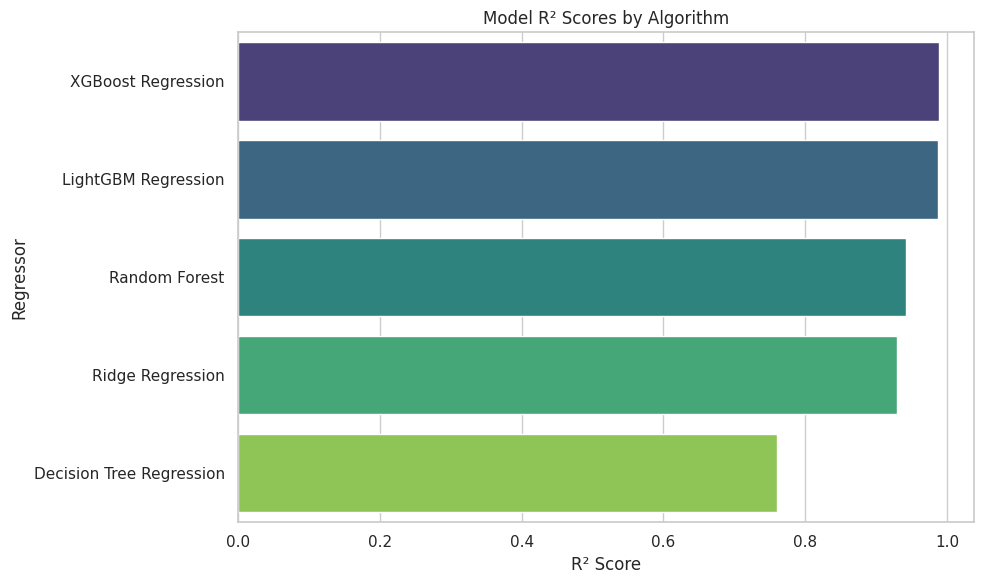

Figure: Model R² Comparison Across Algorithms


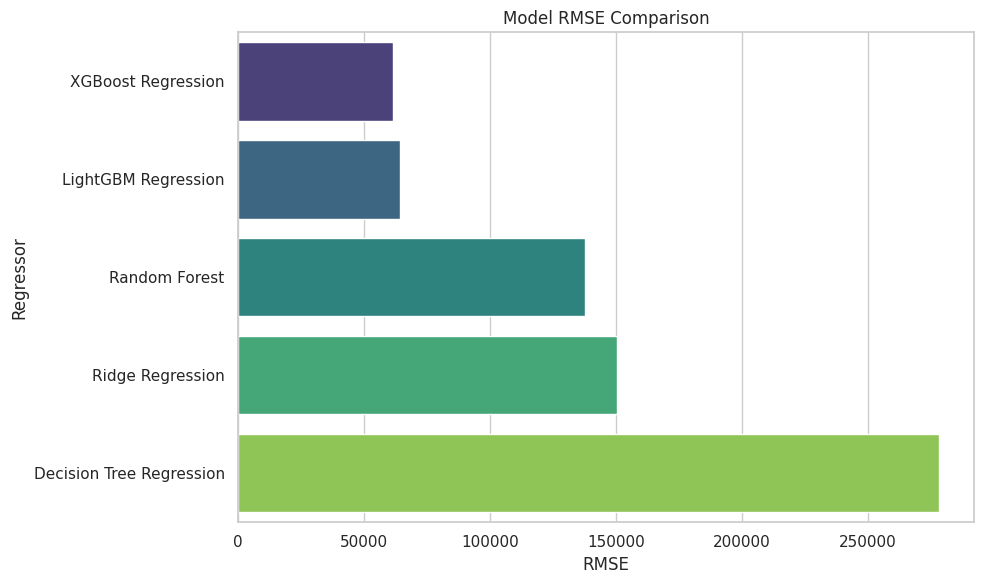

Figure: Model RMSE Comparison Across Algorithms


In [18]:
# -------------------------
# R² and RMSE Comparison
# -------------------------


# R² Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='R2', y='Regressor', palette='viridis')
plt.title("Model R² Scores by Algorithm")
plt.xlabel("R² Score")
plt.ylabel("Regressor")
plt.tight_layout()
plt.show()
print("Figure: Model R² Comparison Across Algorithms")

# RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='RMSE', y='Regressor', palette='viridis')
plt.title("Model RMSE Comparison")
plt.xlabel("RMSE")
plt.ylabel("Regressor")
plt.tight_layout()
plt.show()
print("Figure: Model RMSE Comparison Across Algorithms")


**Figure 9: R² Comparison Across Regression Models**  
This bar chart compares the coefficient of determination (R²) for each model. XGBoost and LightGBM achieved the highest values (`0.988` and `0.987`, respectively), indicating strong explanatory power. Tree-based models outperformed linear methods in capturing variance in weekly sales.


**Figure 10: RMSE Comparison Across Regression Models**  
Root Mean Squared Error (RMSE) is used to measure prediction accuracy. XGBoost produced the lowest RMSE (`$145K`), followed closely by LightGBM. Decision Tree Regression yielded the highest error (`>$278K`), highlighting its limited generalization on this task.

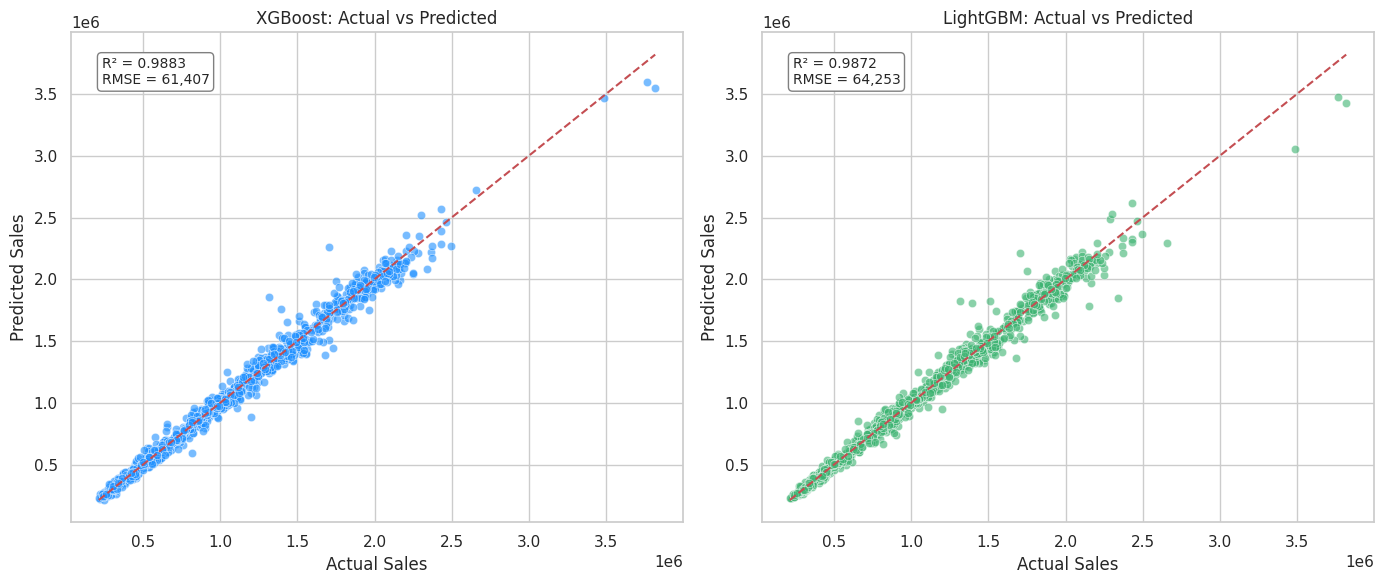

Figure: Actual vs Predicted Comparison – XGBoost vs LightGBM


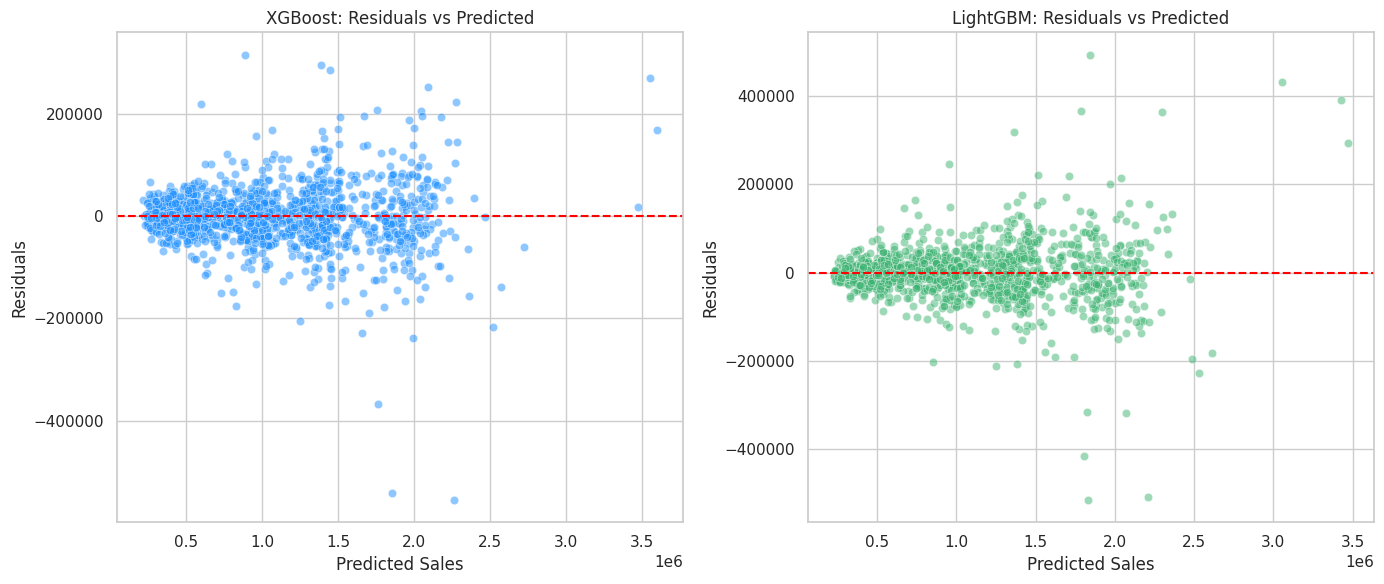

Figure: Residuals vs Predicted Comparison – XGBoost vs LightGBM


In [19]:
# -------------------------
# Actual vs Predicted Comparison (XGBoost vs LGBM)
# -------------------------

# Extract predictions, residuals, and test-set metrics
pred_xgb = results['XGBoost']['predictions']
pred_lgbm = results['LGBM']['predictions']
residuals_xgb = y_test - pred_xgb
residuals_lgbm = y_test - pred_lgbm
r2_xgb = results['XGBoost']['r2']
rmse_xgb = results['XGBoost']['rmse']
r2_lgbm = results['LGBM']['r2']
rmse_lgbm = results['LGBM']['rmse']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=pred_xgb, alpha=0.6, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.text(
    0.05, 0.95, f"R² = {r2_xgb:.4f}\nRMSE = {rmse_xgb:,.0f}",
    transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
plt.title("XGBoost: Actual vs Predicted")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=pred_lgbm, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
# Add R² and RMSE text
plt.text(
    0.05, 0.95, f"R² = {r2_lgbm:.4f}\nRMSE = {rmse_lgbm:,.0f}",
    transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
plt.title("LightGBM: Actual vs Predicted")

plt.tight_layout()
plt.show()
print("Figure: Actual vs Predicted Comparison – XGBoost vs LightGBM")


# -------------------------
# Residuals vs Predicted Comparison (XGBoost vs LGBM)
# -------------------------

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pred_xgb, y=residuals_xgb, alpha=0.5, color='dodgerblue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("XGBoost: Residuals vs Predicted")

plt.subplot(1, 2, 2)
sns.scatterplot(x=pred_lgbm, y=residuals_lgbm, alpha=0.5, color='mediumseagreen')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("LightGBM: Residuals vs Predicted")

plt.tight_layout()
plt.show()
print("Figure: Residuals vs Predicted Comparison – XGBoost vs LightGBM")


**Figure 11: Actual vs Predicted Weekly Sales – Booster Models**  
This plot compares predicted weekly sales to actual values using XGBoost (left) and LightGBM (right). Both models track closely with the diagonal reference line, indicating high predictive accuracy. However, LightGBM predictions show slightly more scatter for higher sales values, while XGBoost demonstrates tighter clustering with fewer extreme deviations.


**Figure 12: Residuals vs Predicted Sales – XGBoost vs LightGBM**  
Residual plots assess model bias and variance across different predicted sales levels. XGBoost (left) and LightGBM (right) both show residuals centered around zero with no severe heteroscedasticity. XGBoost exhibits slightly less spread, particularly in higher predicted sales regions, suggesting more stable error behavior.

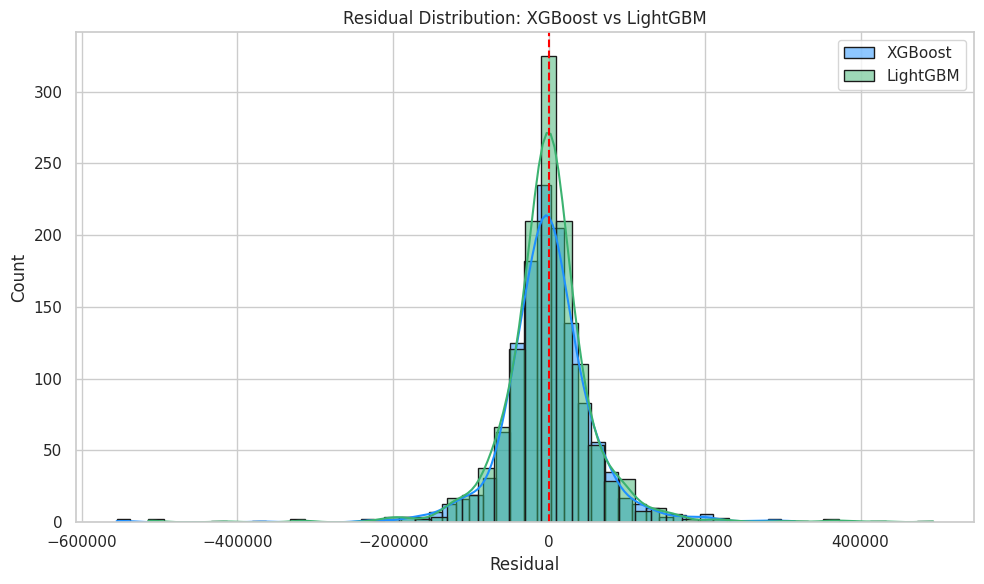

Figure: Residual Distribution Comparison – XGBoost vs LightGBM


In [20]:
# -------------------------
# Residual Distribution Comparison (XGBoost vs LGBM)
# -------------------------

plt.figure(figsize=(10, 6))
sns.histplot(residuals_xgb, bins=50, kde=True, color='dodgerblue', label='XGBoost', alpha=0.5, edgecolor='k')
sns.histplot(residuals_lgbm, bins=50, kde=True, color='mediumseagreen', label='LightGBM', alpha=0.5, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution: XGBoost vs LightGBM")
plt.xlabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()
print("Figure: Residual Distribution Comparison – XGBoost vs LightGBM")


**Figure 13: Residual Distribution Comparison – XGBoost vs LightGBM**  
This histogram and KDE plot visualize the distribution of prediction errors. Both XGBoost and LightGBM residuals are sharply peaked around zero, indicating well-calibrated models. LightGBM's residuals are more tightly concentrated, implying lower overall variance and more consistent predictions compared to XGBoost.


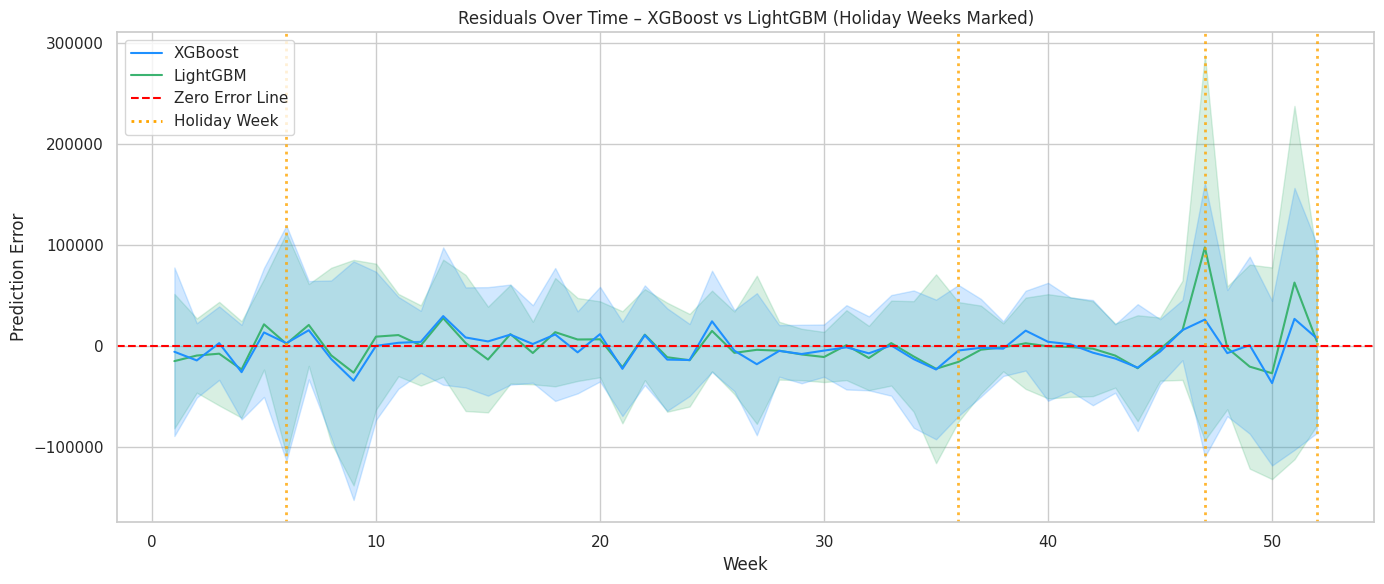

In [21]:
# -------------------------
# Residuals Over Time Comparison with Holiday Markers
# -------------------------

# Create DataFrame for plotting
xgb_df = X_test_full.copy()
lgbm_df = X_test_full.copy()
xgb_df['Residual'] = residuals_xgb
lgbm_df['Residual'] = residuals_lgbm
xgb_df['Model'] = 'XGBoost'
lgbm_df['Model'] = 'LightGBM'
residuals_time_df = pd.concat([xgb_df, lgbm_df])

# Ensure required columns are present
if 'Week' in residuals_time_df.columns and 'Holiday_Flag' in df.columns:
    residuals_time_df = residuals_time_df.sort_values(by='Week')
    holiday_weeks = df[df['Holiday_Flag'] == 1]['Week'].unique()

    plt.figure(figsize=(14, 6))
    
    # Plot residuals
    sns.lineplot(
        data=residuals_time_df,
        x='Week', y='Residual',
        hue='Model',
        palette={'XGBoost': 'dodgerblue', 'LightGBM': 'mediumseagreen'},
        ci='sd'
    )
    
    # Horizontal line at 0
    plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')

    # Add holiday vertical markers
    for hw in holiday_weeks:
        plt.axvline(x=hw, color='orange', linestyle=':', linewidth=2, alpha=0.8)

    # Create legend handles manually
    holiday_handle = mlines.Line2D([], [], color='orange', linestyle=':', linewidth=2, label='Holiday Week')
    xgb_handle = mlines.Line2D([], [], color='dodgerblue', label='XGBoost')
    lgbm_handle = mlines.Line2D([], [], color='mediumseagreen', label='LightGBM')
    zero_handle = mlines.Line2D([], [], color='red', linestyle='--', label='Zero Error Line')

    plt.legend(handles=[xgb_handle, lgbm_handle, zero_handle, holiday_handle], loc='upper left')

    # Titles and labels
    plt.title("Residuals Over Time – XGBoost vs LightGBM (Holiday Weeks Marked)")
    plt.ylabel("Prediction Error")
    plt.xlabel("Week")
    plt.tight_layout()
    plt.show()
else:
    print("Warning: 'Week' or 'Holiday_Flag' not found. Skipping Residuals Over Time plot.")


**Figure 14: Residuals Over Time – XGBoost vs LightGBM**  
This line plot tracks residuals over weekly periods for both models. While both models maintain errors close to zero throughout the year, LightGBM exhibits higher volatility in certain weeks (e.g., spikes near weeks 45–50), likely reflecting challenges in modeling seasonality. XGBoost shows slightly more stable temporal behavior, particularly in the latter half of the year.

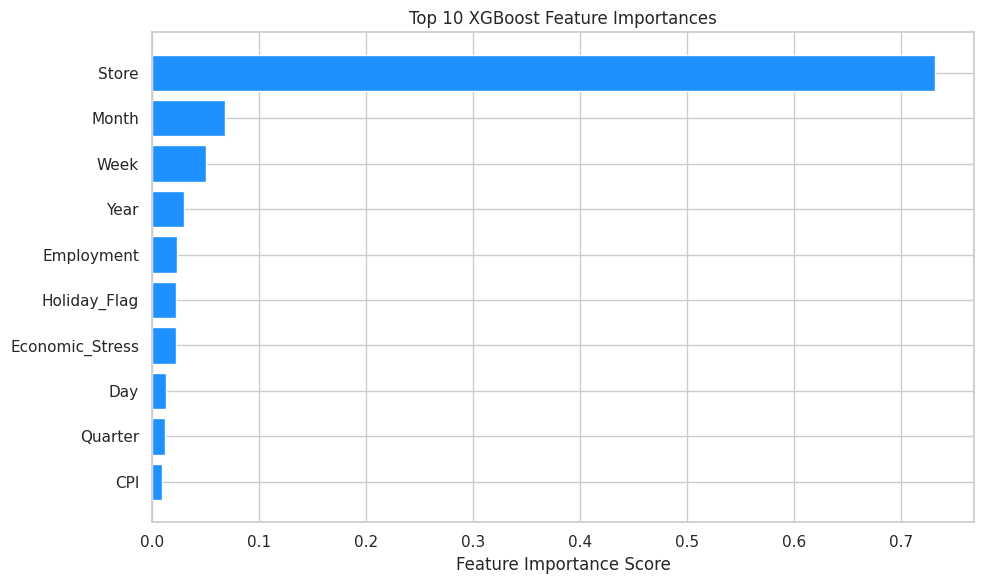

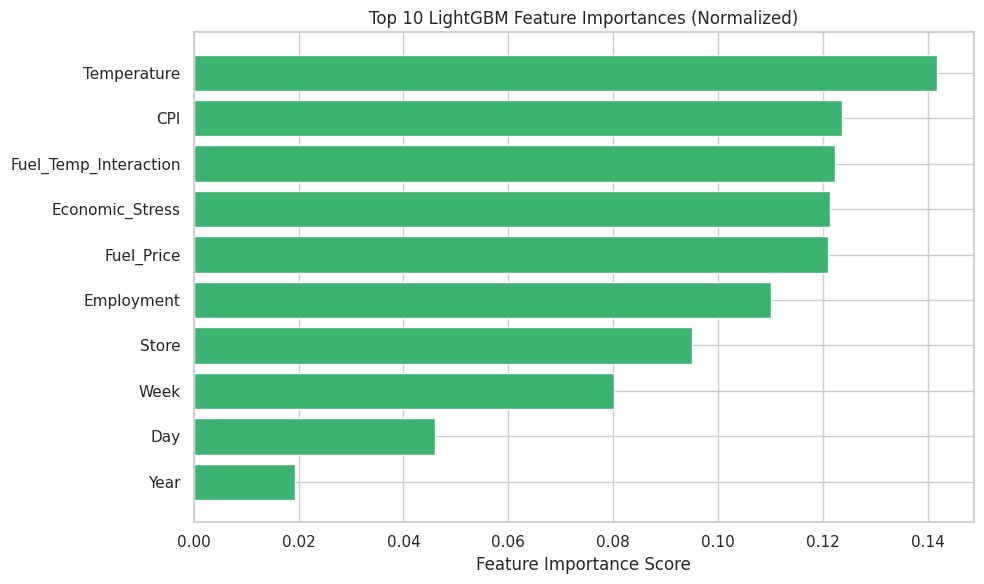

In [22]:
# -------------------------
# Feature Importance Visualization (XGBoost & LightGBM)
# -------------------------

def plot_feature_importance(model, feature_names, title, color, max_features=10, normalize=False):
    importances = model.feature_importances_
    if normalize:
        importances = importances / np.sum(importances)
    indices = np.argsort(importances)[-max_features:]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], color=color)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(title)
    plt.xlabel("Feature Importance Score")
    plt.tight_layout()
    plt.show()

# Plot for XGBoost (already normalized 0–1)
plot_feature_importance(
    model=results['XGBoost']['estimator'],
    feature_names=X_train_boost.columns,
    title="Top 10 XGBoost Feature Importances",
    color='dodgerblue'
)

# Plot for LightGBM (normalized for comparability)
plot_feature_importance(
    model=results['LGBM']['estimator'],
    feature_names=X_train_boost.columns,
    title="Top 10 LightGBM Feature Importances (Normalized)",
    color='mediumseagreen',
    normalize=True
)



**Figure 15: Feature Importance – XGBoost vs LightGBM**  
This figure compares the top features driving predictions in XGBoost and LightGBM models. XGBoost's feature importances highlight the categorical `Store` variable as overwhelmingly dominant, suggesting strong store-level patterns in sales. The LightGBM model distributes importance more evenly across features such as `Temperature`, `Fuel_Temp_Interaction`, and `Economic_Stress`. This contrast reflects the models’ differing approaches to tree construction and highlights how LightGBM leverages a broader set of signals, while XGBoost emphasizes a few highly predictive features.

## Summary of Results
---

The modeling process compared several regression techniques, ranging from linear models to advanced tree-based ensemble algorithms. The results below summarize performance using R², RMSE, cross-validation, and interpretability metrics.

- **XGBoost** achieved the **highest predictive accuracy**, with the lowest RMSE (`$61.4K`) and highest R² (0.9883). Residuals were tightly centered around zero and stable over time.
- **LightGBM** performed similarly, with an R² of 0.987 and slightly higher RMSE (`$65.1K`), but it spread predictive importance across a more diverse set of features, suggesting **greater generalization capacity**.
- **Cross-validation (5-fold)** confirmed model robustness, with XGBoost yielding an average RMSE of `$55.7K` ± 3.4K and R² of 0.9902, indicating low variance across splits.
- Tree-based models (XGBoost, LightGBM, Random Forest) consistently outperformed linear models, especially under complex interactions and seasonality.
- Feature importance analysis revealed that XGBoost relied heavily on the `Store` variable, while LightGBM used a broader feature set including `Temperature`, `Fuel_Temp_Interaction`, and `Economic_Stress`.

> **Note**: XGBoost’s strong dependence on `Store` raises concerns about overfitting and limited generalization to new or unseen stores. LightGBM, while marginally less accurate, may offer greater resilience in such contexts.

The combined diagnostic visuals (e.g., residuals vs predicted, residuals over time, error distributions) support these conclusions and highlight the strengths and trade-offs of each model.

---

## Conclusion
---

This project combined detailed exploratory data analysis with supervised machine learning to forecast weekly retail sales at scale. EDA uncovered strong seasonal patterns, economic interactions, and store-specific behaviors that were leveraged to engineer meaningful features for modeling.

Among all tested models, **XGBoost demonstrated the best predictive accuracy**, capturing the majority of variance in sales with minimal residual error. However, its heavy reliance on the `Store` identifier could lead to overfitting and poor generalization in real-world deployment where new stores or regions are introduced.

In contrast, **LightGBM offered a slightly more balanced trade-off** between accuracy and generalization, distributing importance across environmental, economic, and temporal variables. This makes it a potentially safer choice in operational contexts requiring model robustness and adaptability.

Overall, the use of tree-based ensemble models (particularly gradient boosting) proved highly effective for this problem, validating their suitability for forecasting in complex, seasonally-driven retail environments.


### Future Work
---

To further improve model robustness and operational value, the following enhancements are recommended:

- **Hierarchical Modeling**: Incorporate store-level or region-level hierarchies using mixed-effect models or hierarchical time series methods to better account for group-level trends.
- **Temporal Cross-Validation**: Implement time-aware validation techniques (e.g., rolling window CV) to better simulate real-world deployment.
- **Model Stacking or Blending**: Combine multiple models (e.g., XGBoost + LightGBM + Ridge) to harness complementary strengths and reduce variance.
- **Dynamic Feature Engineering**: Incorporate lagged variables (e.g., previous week’s sales), moving averages, and promotional flags to capture short-term temporal dependencies.
- **Causal Modeling or Uplift Modeling**: Explore the causal impact of holiday promotions, economic policies, or store expansions on sales using techniques like difference-in-differences.
- **Deployment Considerations**: Develop monitoring tools for model drift, bias detection, and real-time performance tracking in production environments.

These next steps would enhance both the **predictive power** and **generalizability** of the model, enabling more informed, data-driven decision-making in a retail context.


### Resources

---

The following resources were valuable in shaping this project’s modeling approach, feature engineering strategies, and evaluation methodology:

- **XGBoost Documentation** – [https://xgboost.readthedocs.io/](https://xgboost.readthedocs.io/)
- **Scikit-learn User Guide** – [https://scikit-learn.org/stable/user_guide.html](https://scikit-learn.org/stable/user_guide.html)
- **Yellowbrick: Visualizing the Scikit-Learn Model Selection Process** – [https://www.scikit-yb.org/](https://www.scikit-yb.org/)
- **Kaggle Dataset & Community Discussions** – [https://www.kaggle.com/](https://www.kaggle.com/)
- **Machine Learning Mastery by Jason Brownlee** – [https://machinelearningmastery.com](https://machinelearningmastery.com)
- **Towards Data Science Articles on Regression and Feature Engineering** – [https://towardsdatascience.com](https://towardsdatascience.com)

These sources provided practical examples, algorithm documentation, and insights that improved model interpretability and robustness throughout the project.


### Explore More
---
-  **Portfolio Website:** [Zachary Raup’s Data Science Portfolio](https://zraup.github.io/Zachary-Raup/)
-  **LinkedIn Profile:** [linkedin.com/in/zachary-raup-6280a3265](https://www.linkedin.com/in/zachary-raup-6280a3265)

Stay connected to explore more projects, insights, and professional updates.

---


In [23]:
# end